In [22]:
# standard libs
import os
import sys
import importlib

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import preprocessing
import prediction_age
import visualizations

importlib.reload(preprocessing)
importlib.reload(prediction_age)
importlib.reload(visualizations)

from prediction_age import AgePredictor
from preprocessing import *

# external libs
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier




## Data

In [ ]:
path_data_france_age = os.path.join('..', 'data_france', 'all_age.csv')
path_data_france_all = os.path.join('..', 'data_france', 'all.csv')

data_france_age = pd.read_csv(path_data_france_age)
data_france_all = pd.read_csv(path_data_france_all)


In [ ]:
data_france_age_sample = data_france_age.sample(frac=.2)
data_france_all_sample = data_france_all.sample(frac=.2)

## Hyperparameters

In [ ]:
# increases computation time 10x compared to defaults
xgb_params_optimal = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

## Preprocessing

## Experiments

In [ ]:
predictor_linear = AgePredictor(
    model=LinearRegression(),
    df=data_france_age,
    test_training_split=split_by_region,
    preprocessing_stages=[remove_other_attributes]
)
predictor_linear.evaluate_regression()

In [ ]:
predictor_rf = AgePredictor(
    model=RandomForestRegressor(),
    df=data_france_age_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_other_attributes]
)
predictor_rf.evaluate_regression()

In [ ]:
predictor_region = AgePredictor(
    model=XGBRegressor(),
    df=data_france_age_sample,
    test_training_split=split_by_region,
    preprocessing_stages=[remove_other_attributes]
)
predictor_region.evaluate_regression()

In [ ]:
predictor_test = AgePredictor(
    model=.XGBRegressor(),
    df=data_france_age_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers, remove_other_attributes, add_noise_feature]
)
predictor_test.evaluate_regression()
predictor_test.feature_dependence_plot("total_ft_area_within_buffer_100", "total_ft_area_within_buffer_500")
predictor_test.feature_dependence_plot("feature_noise", "feature_noise")


In [ ]:
predictor = AgePredictor(
    model=.XGBRegressor(),
    df=data_france_age,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_other_attributes]
)
predictor.evaluate_regression()

In [ ]:
predictor.SHAP_analysis()

In [ ]:
predictor.neighborhood_feature_importance()
predictor.feature_selection()

In [ ]:
# https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html
# https://slundberg.github.io/shap/notebooks/plots/decision_plot.html
# shap.plots.scatter(ex[:,"feature_noise"], color=ex[:,"feature_noise"])
predictor_test.feature_dependence_plot("total_ft_area_within_buffer_100", "total_ft_area_within_buffer_500", transparency=0.1)

In [ ]:
predictor_all_attributes = AgePredictor(
    model=.XGBRegressor(),
    df=data_france_age,
    test_training_split=split_80_20,
    preprocessing_stages=[keep_other_attributes]
)
predictor_all_attributes.evaluate_regression()

In [ ]:
model = .XGBClassifier(objective='multi:softmax', num_class=6, use_label_encoder=False, eval_metric=["merror", "mlogloss"])
classifier = AgePredictor(
    model=model,
    df=data_france_age,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers, remove_other_attributes, categorize_age]
)
classifier.evaluate_classification()

In [ ]:
visualizations.plot_log_loss(classifier.model)
visualizations.plot_classification_error(classifier.model)

In [ ]:
classifier.SHAP_analysis()

In [ ]:
classifier.neighborhood_feature_importance()
classifier.feature_selection()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MAE: 1.0008514833736668 y
RMSE: 1.4702541944349192 y
R2: -0.15905060229343015


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


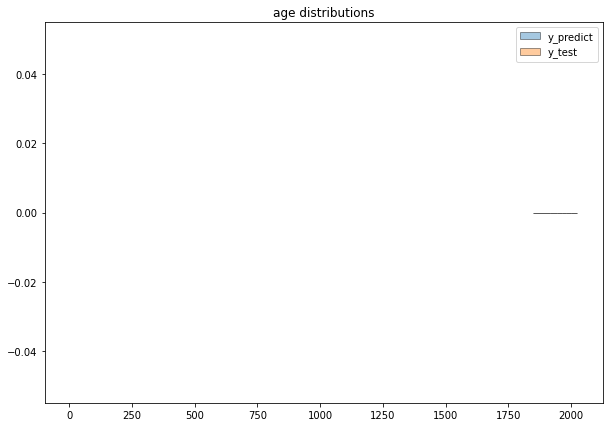

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

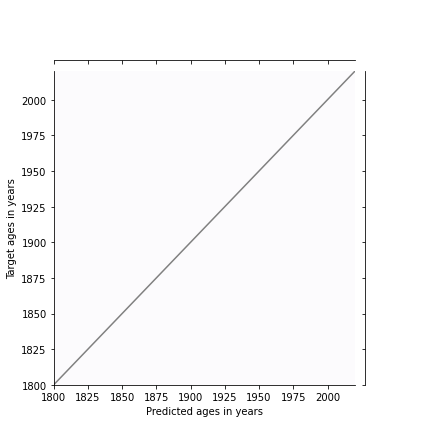

In [23]:
classifier_ada = AgePredictor(
    model=AdaBoostClassifier(),
    df=data_france_age_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers, remove_other_attributes, categorize_age]
)
classifier_ada.evaluate_classification()

## Hyperparameter Tuning

In [ ]:
predictor = AgePredictor(
    model=.XGBRegressor(),
    df=data_france_age_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_other_attributes],
    hyperparameter_tuning=True
)
predictor.evaluate_regression()

In [ ]:
grid_search_results = os.path.join('..', 'notebooks', 'hyperparameter-tuning-results.csv')

df_grid_search = pd.read_csv(grid_search_results, sep='\t')
df_grid_search.sort_values(by=['Accuracy'], ascending=False).head(10)

In [ ]:
regr = LinearRegression()
y = df_grid_search[['Accuracy']]
X = df_grid_search.drop(columns=['Accuracy'])
regr.fit(X, y)
# np.multiply(regr.coef_[0][:-1],[3.5,0.1,500,0.3,0.3])
pd.DataFrame({'feature': df_grid_search.columns[1:],'reg coef': regr.coef_[0]})